In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2
import json
import os
import datetime
import nrrd
import bg_space as bg
from pprint import pprint
from matplotlib.colors import LogNorm, Normalize
import seaborn as sb
import pathlib


In [2]:
image = cv2.imread('/nemo/lab/znamenskiyp/home/shared/projects/turnerb_V1_MAPseq/axonal_BARseq_test/M02011274/chamber_1/hybridization_round_1_1/hybridization_round_1_1_MMStack_1-Pos015_012_max.tif', cv2.IMREAD_UNCHANGED)


channels = cv2.split(image)

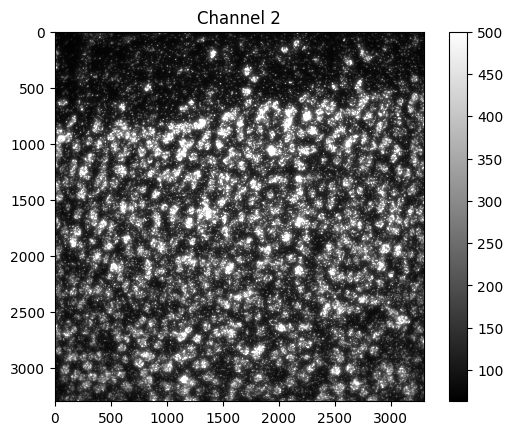

In [25]:

# Load the TIFF file
up_down = '12'
left_right = '13'
tiff_file_path = f'/nemo/lab/znamenskiyp/home/shared/projects/turnerb_V1_MAPseq/axonal_BARseq_test/M02011274/chamber_2/hybridization_round_1_1/hybridization_round_1_1_MMStack_2-Pos0{left_right}_0{up_down}_max.tif'
image_data = tifffile.imread(tiff_file_path)

# Select the channel to plot (assuming 0-based index)
channel_to_plot = 1  # This selects the second channel (index 1)

# Plot the selected channel
plt.imshow(image_data[channel_to_plot], cmap='gray', vmax=500)  
plt.title(f'Channel {channel_to_plot + 1}')
plt.colorbar()
plt.show()


In [ ]:
from bg_atlasapi import BrainGlobeAtlas

In [ ]:
bg_atlas = BrainGlobeAtlas("allen_mouse_25um", check_latest=False

In [ ]:
directory = '/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/reference/final_170123.json' #where registration file is saved
savingpath = ('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/allen_ccf_coord') #where you want to save

In [ ]:
with open(directory) as fp:
  bla = json.load(fp)

In [ ]:
slice_coord = pd.DataFrame(columns=['filename','ox', 'oy', 'oz', 'ux', 'uy', 'uz', 'vx', 'vy', 'vz', 'markers', 'height', 'width'], dtype=int)
for slice in bla["slices"]:
    anchoring = slice["anchoring"]
    slice_coord = slice_coord.append({'filename': slice["filename"], 'ox': (anchoring[0]), 'oy': (anchoring[1]), 'oz': (anchoring[2]), 'ux': (anchoring[3]), 'uy': (anchoring[4]), 'uz': (anchoring[5]), 'vx': (anchoring[6]), 'vy': (anchoring[7]), 'vz': (anchoring[8]), 'markers': (slice["markers"]),'height': (slice["height"]), 'width': (slice["width"])},ignore_index=True)
#incorporate allen conversion units, and subsequently also incorporate functions from NITRC.org
allen_matrix_conv = [[0, 0, 25, 0],
                    [-25, 0, 0, 0],
                    [0, -25, 0, 0],
                    [13175, 7975, 0, 1]]


In [ ]:
def triangulate(w,h,markers):
       vertices=[[-0.1*w,-0.1*h,-0.1*w,-0.1*h],
                 [ 1.1*w,-0.1*h, 1.1*w,-0.1*h],
                 [-0.1*w, 1.1*h,-0.1*w, 1.1*h],
                 [ 1.1*w, 1.1*h, 1.1*w, 1.1*h]]
       edges=[0]*((len(markers)+4)*(len(markers)+4-1)//2)
       triangles=[Triangle(0,1,2,vertices,edges),Triangle(1,2,3,vertices,edges)]
       edges[0]=edges[1]=edges[4]=edges[5]=2
       for marker in markers:
           x,y=marker[2:4]
           found=False
           keep=[]
           remove=[]
           for triangle in triangles:
               if not found and triangle.intriangle(x,y):
                   found=True
               if triangle.incircle(x,y):
                   remove.append(triangle)
               else:
                   keep.append(triangle)
           if found:
               for triangle in remove:
                   triangle.removeedges()
           else:
               keep.extend(remove)
           triangles=keep
           vcount=len(vertices)
           vertices.append(marker)
           for i in range(vcount-1):
               for j in range(i+1,vcount):
                   if edges[edgeindex(i,j)]==1:
                       triangles.append(Triangle(i,j,vcount,vertices,edges))
       return triangles
def transform(triangulation,x,y):
       for triangle in triangulation:
           uv1=triangle.intriangle(x,y)
           if uv1:
               return (triangle.A[0]
                       +(triangle.B[0]-triangle.A[0])*uv1[0]
                       +(triangle.C[0]-triangle.A[0])*uv1[1],
                       triangle.A[1]
                       +(triangle.B[1]-triangle.A[1])*uv1[0]
                       +(triangle.C[1]-triangle.A[1])*uv1[1])
def forwardtransform(triangulation,x,y):
       for triangle in triangulation:
           uv1=triangle.inforward(x,y)
           if uv1:
               return (triangle.A[2]
                     +(triangle.B[2]-triangle.A[2])*uv1[0]
                     +(triangle.C[2]-triangle.A[2])*uv1[1],
                       triangle.A[3]
                     +(triangle.B[3]-triangle.A[3])*uv1[0]
                     +(triangle.C[3]-triangle.A[3])*uv1[1])
def inv3x3(m):
       det = m[0][0] * (m[1][1] * m[2][2] - m[2][1] * m[1][2])\
           - m[0][1] * (m[1][0] * m[2][2] - m[1][2] * m[2][0])\
           + m[0][2] * (m[1][0] * m[2][1] - m[1][1] * m[2][0])
       if det == 0:
           return None
       return [[(m[1][1] * m[2][2] - m[2][1] * m[1][2]) / det,
                (m[0][2] * m[2][1] - m[0][1] * m[2][2]) / det,
                (m[0][1] * m[1][2] - m[0][2] * m[1][1]) / det],
               [(m[1][2] * m[2][0] - m[1][0] * m[2][2]) / det,
                (m[0][0] * m[2][2] - m[0][2] * m[2][0]) / det,
                (m[1][0] * m[0][2] - m[0][0] * m[1][2]) / det],
               [(m[1][0] * m[2][1] - m[2][0] * m[1][1]) / det,
                (m[2][0] * m[0][1] - m[0][0] * m[2][1]) / det,
                (m[0][0] * m[1][1] - m[1][0] * m[0][1]) / det]]
def rowmul3(v,m):return [sum(v[j]*m[j][i] for j in range(3)) for i in range(3)]
def distsquare(ax,ay,bx,by):return (ax-bx)*(ax-bx)+(ay-by)*(ay-by)
def edgeindex(a,b):i=min(a,b);j=max(a,b);return j*(j-1)//2+i


In [ ]:
class Triangle:
   def __init__(self,a,b,c,vlist,elist):
       self.A=vlist[a]
       self.B=vlist[b]
       self.C=vlist[c]
       self.elist=elist
       self.edges=[edgeindex(a,b),
                   edgeindex(a,c),
                   edgeindex(b,c)]
       for edge in self.edges:
           elist[edge]+=1
       ax,ay=self.A[0:2]
       bx,by=self.B[0:2]
       cx,cy=self.C[0:2]
       self.forwarddecomp=inv3x3([[bx-ax,by-ay,0],
                                  [cx-ax,cy-ay,0],
                                  [ax,ay,1]])
       ax,ay=self.A[2:4]
       bx,by=self.B[2:4]
       cx,cy=self.C[2:4]
       self.decomp=inv3x3([[bx-ax,by-ay,0],
                           [cx-ax,cy-ay,0],
                           [ax,ay,1]])
       a2=distsquare(bx,by,cx,cy)
       b2=distsquare(ax,ay,cx,cy)
       c2=distsquare(ax,ay,bx,by)
       fa=a2*(b2+c2-a2)
       fb=b2*(c2+a2-b2)
       fc=c2*(a2+b2-c2)
       self.den=fa+fb+fc
       self.Mdenx=fa*ax+fb*bx+fc*cx
       self.Mdeny=fa*ay+fb*by+fc*cy
       self.r2den=distsquare(ax*self.den,ay*self.den,self.Mdenx,self.Mdeny)

   def removeedges(self):
       for edge in self.edges:
           self.elist[edge]-=1
       del self.edges
       del self.elist

   def incircle(self,x,y):
       return distsquare(x*self.den,y*self.den,self.Mdenx,self.Mdeny)<self.r2den

   def intriangle(self,x,y):
       uv1=rowmul3([x,y,1],self.decomp)
       if 0<=uv1[0]<=1 and 0<=uv1[1]<=1 and uv1[0]+uv1[1]<=1:
           return uv1

   def inforward(self,x,y):
       uv1=rowmul3([x,y,1],self.forwarddecomp)
       if 0<=uv1[0]<=1 and 0<=uv1[1]<=1 and uv1[0]+uv1[1]<=1:
           return uv1

In [ ]:
os.chdir(savingpath)
for i, row in slice_coord['filename'].iteritems():
    print('Performing non-linear deformation for %s. %s' %
            (row[:-len('.jpg')], datetime.datetime.now().strftime('%H:%M:%S')), flush=True)
    which = slice_coord.iloc[i]
    x_val = list(range(0, which['width']))
    y_val = list(range(0, which['height']))
    coord = np.meshgrid(x_val, y_val)
    width=which['width']
    height=which['height']
    newcoord=[]
#perform non-linear deformation of coordinates on each set of section image pixels according info in json file.
    triangulation=triangulate(width,height,which["markers"])
    for x, y in np.nditer(coord):
        i,j=transform(triangulation,x,y)
        nc = (i,j)
        newcoord.append(nc)
#make  new x y matrices of containing new non-linearly deformed coordinates
    gi = pd.DataFrame(newcoord)
    Xt = np.reshape(np.array(gi[0]), (height, width))
    Yt = np.reshape(np.array(gi[1]), (height, width))

#now transform the deformed and registered quickNII image section coordinates to allen ccf
    print('Converting to Allen Coordinates. %s' %
            datetime.datetime.now().strftime('%H:%M:%S'), flush=True)
    U_V_O_vector = [[which['ux'], which['uy'], which['uz']],
                    [which['vx'], which['vy'], which['vz']],
                    [which['ox'], which['oy'], which['oz']]]
#generate 3D voxels from pixel coordinates for each file
    div_h = which['height']-1 #minus one, since u and v vectors vary between 0 and one, and pixels start at 0 (so max Xt/width is 1 only when -1)
    div_w = which['width']-1 #ibid
    [xv,  yv,  zv] = np.matmul([(Xt/div_w),  (Yt/div_h),  1 ], U_V_O_vector)
#transform into allen coord
    filename = 'allen_ccf_converted_%s' %row[:-len('.jpg')]
    [xa, ya, za, one] = np.matmul([xv,  yv,  zv, 1], allen_matrix_conv)
    allen_vox = [xa, ya, za, one]
    np.save(filename, allen_vox)


In [ ]:
#iterate through individual slices, take average difference in in coordinates in z (which is x axes in allen ccf) for last slice (slice s001 for brain 1), take average of previous slices
os.chdir(savingpath)
add_z = pd.DataFrame(columns=['slice', 'amountz'], dtype=int)
#need to change for mega thick last bit of cortex section, so extend ROI through 3slices
for file in os.listdir(savingpath):
    if file.startswith('allen_ccf_converted_'):
        slice_name = file[20:24]
        slicenum = int(file[21:24])
        if slice_name != 's001' and slice_name != 's012' and slice_name != 's048' and slice_name != 's053':
            slice_before= slicenum-1
            if slice_before >9:
                slicebefore_name = 's0%s' %slice_before
            if slice_before<10:
                slicebefore_name = 's00%s' %slice_before
            [x1a, y1a, z1a, one1] = np.load(file)
            [x2a, y2a, z2a, one2] = np.load('allen_ccf_converted_%s.npy' %slicebefore_name)
            dif = np.average(x2a.flatten()-x1a.flatten())
            add_z= add_z.append({'slice': slice_name, 'amountz': dif},ignore_index=True)

In [ ]:
#for slices where the one's before are missing, extend them by the mean of slice z extensions for the others
s001_add =add_z['amountz'].mean()
add_z= add_z.append({'slice': 's001', 'amountz': s001_add},ignore_index=True)
s012_add =add_z['amountz'].mean()
add_z= add_z.append({'slice': 's012', 'amountz': s012_add},ignore_index=True)
s048_add =add_z['amountz'].mean()
add_z= add_z.append({'slice': 's048', 'amountz': s048_add},ignore_index=True)
s053_add =add_z['amountz'].mean()
add_z= add_z.append({'slice': 's053', 'amountz': s053_add},ignore_index=True)

In [ ]:
ROI_vol

In [ ]:
#load annotation
genpath = ('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/')
os.chdir(genpath)
allenanno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allenanno = np.array(allenanno)
annotation = allenanno[0]

In [ ]:
roipath = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/rois')
ROI_vol=pd.DataFrame()
for region in os.listdir(roipath):
    if region.startswith("s0"):
        slicename = region[0:4]
        tube = region[5:len(region)].split('TUBE', 1)[1]
        tube =tube[:-4]
        [xa, ya, za, one] = np.load('allenccf/allen_ccf_coord/allen_ccf_converted_%s.npy' %slicename)
        roi = plt.imread('rois/%s' %region)
        allencoord_roiya = roi*ya
        allencoord_roiza = roi*za
#use shoelace formula to define area of polygon given xy coordinates then calculate volume of each LCM roi
        calcz = allencoord_roiza[allencoord_roiza!= 0]
        calcy = allencoord_roiya[allencoord_roiya!= 0]
        area_roi = 0.5*np.abs(np.dot(calcz,np.roll(calcy,1))-np.dot(calcy,np.roll(calcz,1)))
        z_to_add = add_z.loc[add_z['slice'] == slicename, 'amountz'].iloc[0]
        vol_roi = area_roi*-z_to_add
#convert the x, y, z coordinates to pixel
        pixcoord = []
        for i, axis in enumerate([xa, ya, za]):
            pixel = np.array(np.round(axis/25), dtype=int)
            pixel[pixel <0] = 0
            pixel[pixel >= annotation.shape[i]] = 0
            pixcoord.append(pixel)

# use annotation.json to convert each pixel to region id

        registered_slice = np.zeros(xa.shape, dtype = annotation.dtype)
        a2=annotation[pixcoord[0].flatten(),
                      pixcoord[1].flatten(),
                      pixcoord[2].flatten()].reshape(registered_slice.shape)
        ROIanno = a2*roi
#iterate image by z slices, each additional z, annotate then add to list
        slices = -round(z_to_add/25)
        for x in range(slices):
            if x >0:
                newz = pixcoord[0]-x #changed from plus to minus as going backwards
                slice = annotation[newz.flatten(), pixcoord[1].flatten(), pixcoord[2].flatten()].reshape(registered_slice.shape)
                ROIanno_add = slice*roi
                ROIanno = np.append(ROIanno, ROIanno_add)
    
        unique, counts = np.unique(ROIanno, return_counts=True)
        region_vol = (counts/sum(counts))*vol_roi
        ROI_vol= ROI_vol.append({'slice': slicename, 'tube': tube, 'z_added': z_to_add, 'vol (um3)': vol_roi, 'region_pix': ROIanno, 'unique_regions': unique[1:], 'region_vol (um3)': region_vol[1:]},ignore_index=True)



In [ ]:
annotation.shape

In [ ]:
ROI_savingpath = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/')
ROI_vol.to_pickle(ROI_savingpath/"ROI_vol.pkl")


In [ ]:
ROI_savingpath/"ROI_vol.pkl"

In [ ]:
#combine volumes for LCM
finalpix = pd.DataFrame(columns=['tube', 'combined_pix', 'vol (um3)'], dtype=int)
result = ROI_vol.groupby(['tube']).agg(', '.join).reset_index()

In [ ]:
for row, tube in result['tube'].iteritems():
    newdf = ROI_vol[ROI_vol['tube']==tube].reset_index()
    #for count, value in enumerate(newdf):
    for r, t in newdf['tube'].iteritems():
        if r ==0 :
            array = newdf.loc[r, 'region_pix']
            vol = newdf.loc[r, 'vol (um3)']
        if r > 0:
            nextarray = newdf.loc[r, 'region_pix']
            vol = vol + newdf.loc[r, 'vol (um3)']
            array = np.concatenate((array, nextarray), axis=None)
    finalpix= finalpix.append({'tube': tube, 'combined_pix': array, 'vol (um3)': vol},ignore_index=True)

In [ ]:
#generate list of unique id regions in all samples
for r, tube in finalpix['tube'].iteritems():
    if r ==0 :
        array = finalpix.loc[r, 'combined_pix']
    if r > 0:
        nextarray = finalpix.loc[r, 'combined_pix']
    array = np.concatenate((array, nextarray), axis=None)
all_regions= np.unique(array)
regioncol =  all_regions[all_regions!= 0]
#calculate region volume in each tube, then create a heatmap of regions coloured according to region
finalpix.tube = finalpix.tube.astype(float)
finalpix1 =finalpix.sort_values('tube').reset_index()
np.save('regioncol.npy', regioncol)
finalpix1.to_pickle("finalpix1.pkl")
finalpix.topickle("finalpix.pkl")

In [ ]:
finalpix1

In [ ]:
newpath = ('/camp/lab/znamenskiyp/home/shared/code/MAPseq_processing/AC_MAPseq/Brain1_FIAA32.6a/LCM_registration')
os.chdir(newpath)

In [ ]:
finalpix1= pd.read_pickle("finalpix1.pkl")

In [ ]:
regioncol = np.load("regioncol.npy")

In [ ]:
finalpix1.iloc[89]['combined_pix']

In [ ]:
#now generate empty table for the acronymns of all areas based on allen ccf
acronymncol = []
for id in regioncol:
    if bg_atlas.structures[id]['acronym'][-1].isnumeric():
        newid = bg_atlas.structures[id]["structure_id_path"][-2] #moving one level up the hierarchy if cortical layer
    elif bg_atlas.structures[id]['acronym'][-2:]== '6a' or bg_atlas.structures[id]['acronym'][-2:]== '6b':
        newid = bg_atlas.structures[id]["structure_id_path"][-2] #moving one level up the hierarchy if layer 6a/6b
    else: newid = id
    acronymn = bg_atlas.structures[newid]['acronym']
    acronymncol.append(acronymn)
acronymncol= np.unique(acronymncol).tolist()
region_table = pd.DataFrame(columns = acronymncol, dtype =int)

In [ ]:
#need to generate reference table to convert id's into higher bit of hierarchy.

for row, tube in finalpix1['tube'].iteritems():
    regions = finalpix1.loc[row, 'combined_pix']
    unique, counts = np.unique(regions, return_counts=True)
    region_area = (counts/sum(counts))*(finalpix1.loc[row, 'vol (um3)'])
    regions = unique[1:]
    region_area = region_area[1:]
    values = regions, region_area
    region_table.at[row, 'sample'] = tube
    index = -1
    if regions.size != 0:
        for id in np.nditer(regions):
            index += 1
            if bg_atlas.structures[id]['acronym'][-1].isnumeric():
                newid = bg_atlas.structures[id]["structure_id_path"][-2] #moving one level up the hierarchy if cortical layer
            elif bg_atlas.structures[id]['acronym'][-2:]== '6a' or bg_atlas.structures[id]['acronym'][-2:]== '6b':
                newid = bg_atlas.structures[id]["structure_id_path"][-2] #moving one level up the hierarchy if layer 6a/6b
            else: newid = id
            acronym = bg_atlas.structures[newid]['acronym']
            region_table.at[row, acronym]= region_area[index]



In [ ]:
region_tab_contra = region_table
#take areas in samples of contralateral hemisphere, and re-label as belonging to contra
contra_samples = [38, 57, 58, 71]
for i, row in region_table.iterrows():
    if region_table['sample'].iloc[i] in contra_samples:
        for col in region_table.columns:
            if col != 'sample'and col.startswith('Contra')==False and np.isnan(region_table[col].iloc[i])== False:
                newcol = 'Contra-' + col
                if newcol not in region_tab_contra:
                    region_tab_contra[newcol]=0
                region_tab_contra[newcol].iloc[i] = region_table[col].iloc[i]
                region_tab_contra[col].iloc[i] =0
            
nozero = region_table.fillna(0)

In [ ]:
nozero.to_csv('3d_areas.csv',index=False)

In [ ]:
region_table

In [ ]:
id = 269
if bg_atlas.structures[id]['acronym'][-2:]== '6a' or bg_atlas.structures[id]['acronym'][-2:]== '6b':
    print('yes')

In [ ]:
bg_atlas.structures[251]['acronym'][-2:]

In [ ]:
df= nozero.reindex(sorted(nozero.columns), axis=1)
df= df.drop(['sample'], axis=1)

fig, ax = plt.subplots(figsize=(60, 10))
sb.heatmap(df, norm=LogNorm(), cbar_kws={'label': 'Vol (um3)'})
ax.set(xlabel="Brain region",
      ylabel="Sample")

plt.savefig('region_heatmap.png')
plt.show()

In [ ]:
bg_atlas.structures[bg_atlas.structures[78]["structure_id_path"][-2]]['acronym']

In [ ]:
finalpix.tube = finalpix.tube.astype(float)
finalpix1 =finalpix.sort_values('tube').reset_index()